In [ ]:
!pip install matplotli bpytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 25.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 23.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 28.1 MB/s eta 0:00:00


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | unet       | UNet       | 948 K  | train
1 | controlnet | ControlNet | 1.2 M  | train
--------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.485     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/tmp/ipykernel_493/694206208.py:331: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pat

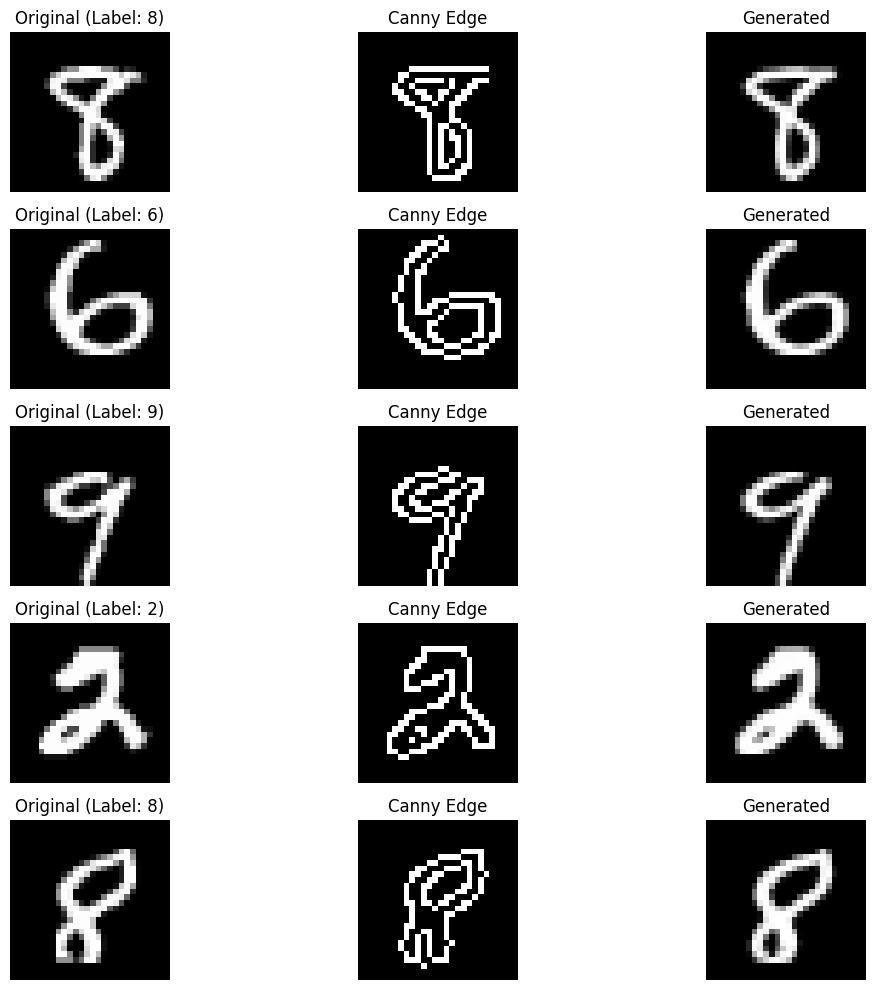

In [ ]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Import classes and constants from your module
from models.ControlNet import (
    CannyEdgeMNIST,
    ControlNetMNIST,
    BATCH_SIZE,
    NUM_EPOCHS)

def main():
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = CannyEdgeMNIST(root_dir='./data', train=True, transform=transform, download=True)
    val_dataset = CannyEdgeMNIST(root_dir='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

    model = ControlNetMNIST(lr=0.001)

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='controlnet-mnist-{epoch:02d}-{val_loss:.4f}',
        save_top_k=3,
        mode='min'
    )
    logger = TensorBoardLogger('logs', name='controlnet_mnist')

    trainer = pl.Trainer(
        max_epochs=NUM_EPOCHS,
        callbacks=[checkpoint_callback],
        logger=logger,
        accelerator='auto'  # Uses GPU if available
    )
    trainer.fit(model, train_loader, val_loader)

    torch.save(model.state_dict(), 'controlnet_mnist_final.pt')
    print("Training complete and model saved to 'controlnet_mnist_final.pt'")

    test_dataset = CannyEdgeMNIST(root_dir='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)
    imgs, edges, labels = next(iter(test_loader))

    model.eval()
    with torch.no_grad():
        zeros = torch.zeros_like(imgs)
        generated = model(zeros, edges)

    fig, axs = plt.subplots(5, 3, figsize=(12, 10))
    for i in range(5):
        axs[i, 0].imshow(imgs[i].squeeze().cpu().numpy(), cmap='gray')
        axs[i, 0].set_title(f'Original (Label: {labels[i].item()})')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(edges[i].squeeze().cpu().numpy(), cmap='gray')
        axs[i, 1].set_title('Canny Edge')
        axs[i, 1].axis('off')
        axs[i, 2].imshow(generated[i].squeeze().cpu().numpy(), cmap='gray')
        axs[i, 2].set_title('Generated')
        axs[i, 2].axis('off')
    plt.tight_layout()
    plt.savefig('controlnet_mnist_test.png')
    plt.show()

if __name__ == "__main__":
    pl.seed_everything(42)
    main()
